## Imort Libraries

In [45]:
import glob
from tqdm import tqdm
import datetime
import re
import pandas as pd
import seaborn as sns
import warnings
import os
import pickle
import numpy as np
import utils as ut
import math
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.stats import norm
import matplotlib.patches as mpatches
import matplotlib
from scipy import stats
import matplotlib.colors as mcolors
from matplotlib.ticker import ScalarFormatter, MaxNLocator
import PA_Utils as pa_ut
from matplotlib.backends.backend_pdf import PdfPages
import statsmodels.api as sm

warnings.simplefilter(action='ignore', category=FutureWarning)
# show all columns of dataframe
pd.set_option('display.max_columns', None)

## Functions

In [2]:
def get_animal_data(data_path, Animal_ID, protocol, data_type):
    """
    Args:
        data_path (str): path to the data folder
        Animal_ID (str): animal ID
        protocol (str): protocol name
        data_type (str): data type (e.g. 'Trial_Summary', 'Detected_Licks')
    Returns:
        animal_df (pd.DataFrame): dataframe containing all the data for the animal
    """

    subject_folders = glob.glob(data_path + Animal_ID +'/*') 
    protocol_folders = list(filter(lambda x: protocol in x, subject_folders)) 

    if len(protocol_folders) == 0:
        warnings.warn(f"{Animal_ID}: all_folders empty")
        return 0

    sessions_data = []
    for folder in tqdm(protocol_folders, position=0, leave=True, desc = 'Processing ' + Animal_ID ):  
        folder_files = glob.glob(folder +'/**/'+data_type +'*.csv', recursive = True)
        for file in folder_files:
            try:
                session_df = pd.read_csv(file)
                date_pattern = r'\d{4}_\d{1,2}_\d{1,2}'
                date = re.search(date_pattern, file).group(0)
                date_obj = datetime.datetime.strptime(date, '%Y_%m_%d')
                formatted_date = date_obj.strftime('%Y/%m/%d')
                session_df.insert(0, 'Date', formatted_date)
                session_df['File_ID'] = file  # Add file identifier
                sessions_data.append(session_df)
            except pd.errors.EmptyDataError:
                pass

        animal_df = pd.concat(sessions_data, axis=0, ignore_index=True)
        # Create a list of columns for sorting
        sort_columns = ['Date']

        # Check which of the columns ('Trial_End_Time' or 'Time') exists in the DataFrame
        if 'Trial_End_Time' in animal_df.columns:
            sort_columns.append('Trial_End_Time')
        elif 'Time' in animal_df.columns:
            sort_columns.append('Time')

        # Sort the DataFrame by the determined columns
        animal_df = animal_df.sort_values(by=sort_columns)

        date_list = []
        for date in animal_df.Date.unique():
            date_df = animal_df[animal_df.Date == date].reset_index(drop=True)
            date_list.append(date_df)
            
        animal_df = pd.concat(date_list, axis=0, ignore_index=True)

    return animal_df

def remap_values(df, column_info):
    '''
    Remaps values in a dataframe according to the value_mapping dict in column_info
    Args:
        df (pd.DataFrame): dataframe to be remapped
        column_info (dict): dictionary containing information about the columns
    Returns:
        df (pd.DataFrame): remapped dataframe
    '''
    for col, info in column_info.items():
        if col in df.columns and info['value_mapping']:
            for new_val, old_vals in info['value_mapping'].items():
                df[col] = df[col].replace(old_vals, new_val)
    return df

def check_and_convert_dtypes(df, column_info):
    '''
    Checks if the dtypes of the columns in the dataframe match the expected dtypes in column_info
    and converts them if necessary
    Args:
        df (pd.DataFrame): dataframe to be checked
        column_info (dict): dictionary containing information about the columns
    Returns:
        df (pd.DataFrame): dataframe with converted dtypes
    '''
    for col, info in column_info.items():
        if col in df.columns:
            expected_dtype = info['dtype']
            if df[col].dtype != expected_dtype:
                try:
                    df[col] = df[col].astype(expected_dtype)
                except ValueError:
                    print(f"Warning: Could not convert column {col} to {expected_dtype}")
    return df

def standardize_dataframe(df, column_info):
    '''
    Standardizes the dataframe by renaming columns, filtering columns, remapping values and converting dtypes
    If certain columns are missing, they are added (potentially future arguments to choose whether to add them or not)
    Args:
        df (pd.DataFrame): dataframe to be standardized
        column_info (dict): dictionary containing information about the columns
    Returns:
        cleaned_df (pd.DataFrame): standardized dataframe
    '''
    rename_dict = {old_name: new_name for new_name, info in column_info.items() if info['rename'] for old_name in info['rename']}

    cleaned_df_list = []

    # look through all File_IDs and re-index the 'Trial' column, then re-assign the df
    for file_id in df['File_ID'].unique():
        file_df = df[df['File_ID'] == file_id]
        # drop all columns that are fully NaN
        file_df = file_df.dropna(axis=1, how='all')
        # rename columns
        file_df = file_df.rename(columns=rename_dict)
        # only keep columns that are in the column_info dict
        # file_df = file_df[[col for col in file_df.columns if col in column_info]]

        # remap values
        file_df = remap_values(file_df, column_info)

        file_df = check_and_convert_dtypes(file_df, column_info)

        # re-index the 'Trial' column
        file_df['Trial'] = file_df['Trial'].rank(method='dense').astype('Int64')
        # Special handling for the 'choice' column
        if 'choice' in file_df.columns and 2 in file_df['choice'].values:
            file_df['choice'] = file_df['choice'] - 1

        # if 'trial_outcome' is missing, add it
        if 'Trial_Outcome' not in file_df.columns:
            # check if 'correct' and 'no_response' are present
            if 'correct' in file_df.columns and 'no_response' in file_df.columns:
            #     # Define conditions
            #     conditions = [
            #         (file_df['correct'] == 1) & (file_df['no_response'] == False),
            #         (file_df['correct'] == 0) & (file_df['no_response'] == False),
            #         file_df['no_response'] == True
            #     ]
                
            #     # Define choices corresponding to conditions
            #     outcomes = ['Correct', 'Incorrect', 'No_Response']
                
            #     # Use numpy select to apply conditions and choices
            #     file_df['Trial_Outcome'] = np.select(conditions, outcomes, default='Unknown')
            # else:
            #     file_df['Trial_Outcome'] = np.nan

                file_df.loc[(file_df['correct'] == 1) & ~file_df['no_response'], 'Trial_Outcome'] = 'Correct'
                file_df.loc[(file_df['correct'] == 0) & ~file_df['no_response'], 'Trial_Outcome'] = 'Incorrect'
                file_df.loc[file_df['no_response'], 'Trial_Outcome'] = 'No_Response'
                file_df['Trial_Outcome'].fillna('Unknown', inplace=True)

        if 'Stim_Relative' not in file_df.columns and 'WN_Amp' in file_df.columns:
            file_df['Stim_Relative'] = file_df['WN_Amp'].apply(lambda x: convert_value(x, 
                                                                                       original_min=50, original_max=82, 
                                                                                       new_min=-1, new_max=1))
        if 'Nb_Of_Stim' not in file_df.columns and file_df['Stage'].iloc[0] != 'Full_Task_Cont':
            try:
                file_df['Nb_Of_Stim'] = len(file_df.Stim_Relative.unique()) 
            except AttributeError:
                file_df['Nb_Of_Stim'] = np.nan
 
        # only keep columns that are in the column_info dict
        file_df = file_df[[col for col in file_df.columns if col in column_info]]

        cleaned_df_list.append(file_df)

        

    cleaned_df = pd.concat(cleaned_df_list, ignore_index=True)
    return cleaned_df

def convert_value(original_value, original_min=50, original_max=82, new_min=-1, new_max=1):
    # Translate original_value to the new range
    return (original_value - original_min) * (new_max - new_min) / (original_max - original_min) + new_min



## Set plot fonts

In [146]:
ut.set_plot_font(font_family='sans-serif', title_font_size=14, label_font_size=14, sans_serif_font='Helvetica')

## Fetch Data

In [7]:
# data_path = '/Users/quentin/Desktop/Python_Sandbox/'
data_path = '/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/'
protocol = 'SOUND_CAT'
data_type = 'Trial_Summary'
animal = 'QP093'

df = get_animal_data(data_path, animal, protocol, data_type)
all_data = df

/var/folders/36/99q57ldx4j956537wjswtd4c0000gn/T/ipykernel_45002/68481050.py:16: UserWarning: QP093: all_folders empty
  warnings.warn(f"{Animal_ID}: all_folders empty")


In [46]:
data_path = '/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/'
protocol = 'SOUND_CAT'
data_type = 'Trial_Summary'

Animal_List = ['QP093', 'QP094', 'QP096', 'QP097', 'QP098', 'QP099', 'QP0100', 'QP0101', 'QP0102', 'QP0103']

# Define the path to the cache file
cache_path = '/Users/quentin/Desktop/HeadFixedBehavior/Data/'
cache_file = os.path.join(cache_path, "all_data_concat.pkl")

# Define the path to the figures
figs_path = '/Users/quentin/Desktop/HeadFixedBehavior/Analysis/Figures/'

# Check if the cache file exists
if os.path.exists(cache_file):
    # If the cache file exists, load the data from the cache
    with open(cache_file, "rb") as f:       
        all_data_SC = pickle.load(f)
else:
    # If the cache file does not exist, load the data from the remote server
    all_data_SC = pd.DataFrame()
    for animal in Animal_List:
        try:
            # Load the data for the current animal and add it to the dictionary
            animal_data = get_animal_data(data_path,
                                             animal, 
                                             protocol,
                                             data_type)
            all_data_SC = pd.concat([all_data_SC, animal_data])
        except:
            # If there is an error loading the data, skip the current animal
            pass

    # Save the data to the cache file
    with open(cache_file, "wb") as f:
        pickle.dump(all_data_SC, f)

## Standardize Dataframe

In [47]:
column_info = {
    'Date': {'dtype': str, 
             'rename': None, 
             'value_mapping': None},
    'Participant_ID': {'dtype': str, 
                       'rename': ['Animal_ID'], 
                       'value_mapping': None},
    'Protocol': {'dtype': str,
                 'rename': None,
                 'value_mapping': None},
    'Stage': {'dtype': str,
                'rename': None,
                'value_mapping': {'Habituation': [1, 'Habituation'],
                                  'Lick_To_Release': [2, 'Lick_To_Release'],
                                  'Three_And_Three': [3, 'Three_And_Three'],
                                  'Full_Task_Disc': [4, 'Full_Task_Disc'],
                                  'Full_Task_Cont': [5, 'Full_Task_Cont']}},
    'Trial': {'dtype': 'Int64',
                'rename': ['TrialNumber', 'Trial_Number'],
                'value_mapping': None},
    'choice': {'dtype': 'Int64', 
               'rename': ['FirstLick'], 
               'value_mapping': {0: 'Left', 1: 'Right'}},
    'Stim_Relative': {'dtype': float,
                        'rename': None,
                        'value_mapping': None},
    'correct': {'dtype': 'Int64',
                'rename': ['Correct', 'correct'],
                'value_mapping': {1: [True, '1', 'True'],
                                  0: [False, '0', 'False']}},
    'Trial_Outcome': {'dtype': str, 
                      'rename': ['TrialOutcome'], 
                      'value_mapping': {'Correct': ['Correct', 'correct', 1], 
                                        'Incorrect': ['Incorrect', 'incorrect', 0], 
                                        'No_Response': ['No Response', 'no_response', -1, 'Abort']}},
    'no_response': {'dtype': bool,
                    'rename': ['AbortTrial', 'Abort_Trial'],
                    'value_mapping': None},
    'Response_Latency': {'dtype': float,
                        'rename': None,
                        'value_mapping': None},
    'Nb_Of_Stim': {'dtype': 'Int32',
                    'rename': None,
                    'value_mapping': None},
    'Stim_Type': {'dtype': str,
                  'rename': None,
                  'value_mapping': None},
    'Anti_Bias': {'dtype': bool,
                  'rename': ['AntiBias', 'Anti_Bias'],
                  'value_mapping': None},
    'Sound_Contingency': {'dtype': str,
                          'rename': None,
                          'value_mapping': None},
    'P_Right': {'dtype': float,
                'rename': None,
                'value_mapping': None},
    'Distribution': {'dtype': str,
                     'rename': None,
                     'value_mapping': None},
    'Trial_End_Time': {'dtype': float,
                      'rename': ['Time', 'Trial_End_Time'],
                      'value_mapping': None},
    'File_ID': {'dtype': str,   
                   'rename': None,
                   'value_mapping': None},
}


In [48]:
all_data_cleaned = standardize_dataframe(all_data_SC, column_info)
all_data_cleaned = all_data_cleaned[all_data_cleaned['correct'].isin([0,1])]
# all_data_cleaned = all_data_cleaned[all_data_cleaned['Stage'].isin(['Full_Task_Disc'])]
all_data_cleaned['Nb_Of_Stim'] = all_data_cleaned['Nb_Of_Stim'].astype('category')

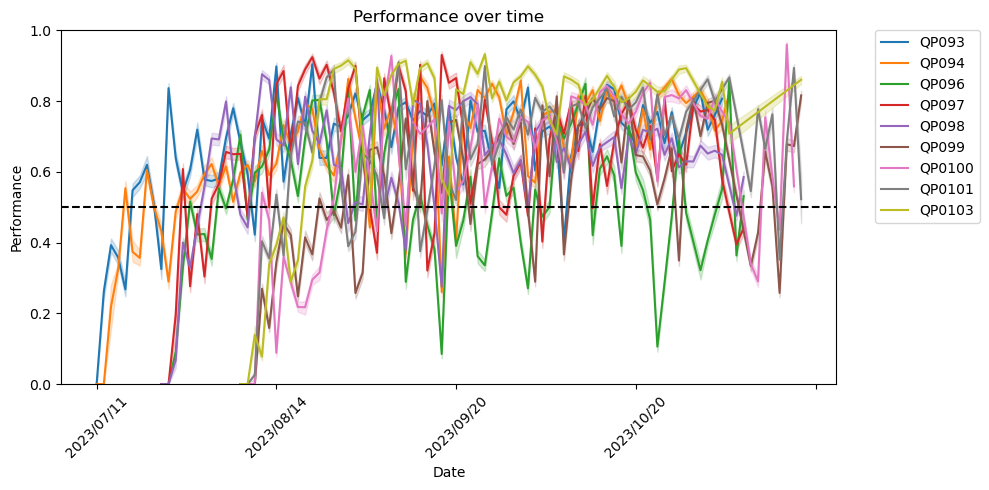

In [49]:
# drop rows where 'correct' is not in [0, 1]
all_data_cleaned = all_data_cleaned[all_data_cleaned['correct'].isin([0, 1])]

# plot performance
fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(data=all_data_cleaned, x='Date', y='correct', ax=ax, hue = 'Participant_ID', ci=68)
ax.axhline(0.5, color='k', linestyle='--')
ax.set_ylim(0, 1)
ax.xaxis.set_major_locator(MaxNLocator(5))
ax.tick_params(axis='x', rotation=45)
# re-index the x-axis to get values starting at 1 and ascending by 1
ax.set_xlabel('Date')
ax.set_ylabel('Performance')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
ax.set_title('Performance over time')
plt.tight_layout()
plt.show()

## Effects of increasing the number of stimuli

In [57]:
# I want a dicotinary where I can have Animal ID, and then start and end dates of 2 types
# discrete-discrete transition
# discrete-continuous transition

transition_dict = {
     'QP069': {
        'discrete_discrete': {
            'start_date': '2023/08/20',
            'transition_date': '2023/08/25',
            'end_date': '2023/08/29',
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },
     'QP077': {
        'discrete_discrete': {
            'start_date': '2023/09/08',
            'transition_date': '2023/09/18',
            'end_date': '2023/10/18',
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },
    'QP083': {
        'discrete_discrete': {
            'start_date': '2023/09/07',
            'transition_date': '2023/09/13',
            'end_date': '2023/10/03',
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },
     'QP084': {
        'discrete_discrete': {
            'start_date': '2023/09/05',
            'transition_date': '2023/10/06',
            'end_date': '2023/10/21'
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },
     'QP085': {
        'discrete_discrete': {
            'start_date': '2023/09/15',
            'transition_date': '2023/09/23',
            'end_date': '2023/09/29',
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },
    'QP092': {
        'discrete_discrete': {
            'start_date': '2023/09/20',
            'transition_date': '2023/09/30',
            'end_date': '2023/10/11'
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },
    'QP093': {
        'discrete_discrete': {
            'start_date': '2023/08/10',
            'transition_date': '2023/08/15',
            'end_date': '2023/08/17'
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },
    'QP094': {
        'discrete_discrete': {
            'start_date': '2023/08/24',
            'transition_date': '2023/08/30',
            'end_date': '2023/09/05'
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },
    'QP097': {
        'discrete_discrete': {
            'start_date': '2023/08/21',
            'transition_date': '2023/08/25',
            'end_date': '2023/08/30'
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },
    'QP098': {
        'discrete_discrete': {
            'start_date': '2023/08/21',
            'transition_date': '2023/08/24',
            'end_date': '2023/08/29',
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },    
    'QP099': {
        'discrete_discrete': {
            'start_date': '2023/10/03',
            'transition_date': '2023/10/06',
            'end_date': '2023/10/10',
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },
    'QP0100': {
        'discrete_discrete': {
            'start_date': '2023/09/09',
            'transition_date': '2023/09/12',
            'end_date': '2023/09/14',
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },
    'QP0101': {
        'discrete_discrete': {
            'start_date': '2023/08/27',
            'transition_date': '2023/09/01',
            'end_date': '2023/09/04',
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },
    'QP0103': {
        'discrete_discrete': {
            'start_date': '2023/09/12',
            'transition_date': '2023/09/14',
            'end_date': '2023/09/18',
        },
        'discrete_continuous': {
            'start_date': np.nan,
            'transition_date': np.nan,
            'end_date': np.nan,
        }
    },
}


In [13]:
# break execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

In [80]:
# select data only for QP092
animal = 'QP0103'
transiton_type = 'discrete_discrete'
filter_date = False
start_date = transition_dict[animal][transiton_type]['start_date']
end_date = transition_dict[animal][transiton_type]['end_date']

transition_date = transition_dict[animal][transiton_type]['transition_date']
plot_transition = True

sub_df = all_data_cleaned[all_data_cleaned['Participant_ID'] == animal].reset_index(drop=True)
sub_df = sub_df[sub_df.Stage == 'Full_Task_Disc'].reset_index(drop=True)
sub_df = sub_df[sub_df['correct'].isin([0, 1])].reset_index(drop=True)
sub_df['Nb_Of_Stim'] = sub_df['Nb_Of_Stim'].astype('category')
# remove no_response trials
sub_df = sub_df[sub_df['no_response'] == False].reset_index(drop=True)
#
if filter_date:
    sub_df = sub_df[(sub_df.Date >= start_date) & (sub_df.Date <= end_date)].reset_index(drop=True)

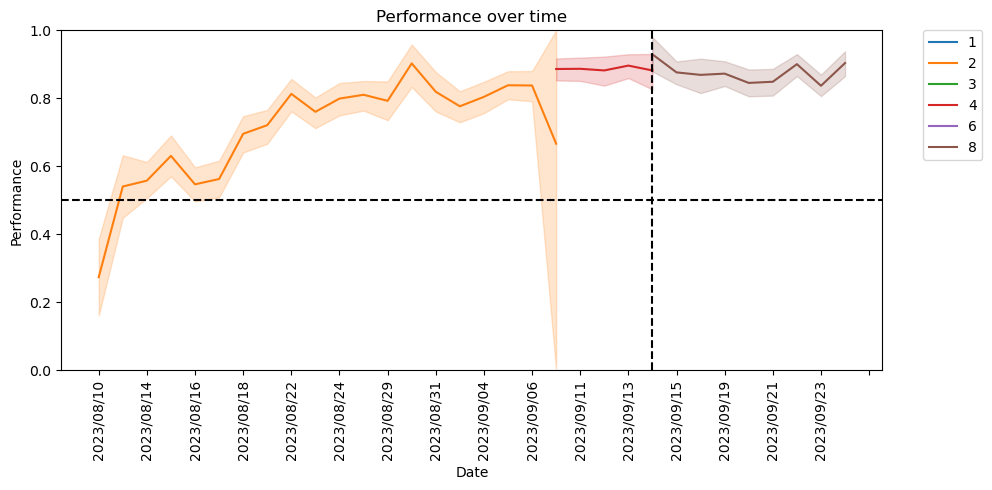

In [81]:
fig, ax = plt.subplots(figsize=(10, 5))

sns.lineplot(data=sub_df, x='Date', y='correct', ax=ax,
                hue = 'Nb_Of_Stim',
                # hue = 'Stage',
                ci=95)
ax.axhline(0.5, color='k', linestyle='--')
ax.set_ylim(0, 1)
ax.xaxis.set_major_locator(MaxNLocator(20))
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('Date')
ax.set_ylabel('Performance')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
if plot_transition:
    ax.axvline(transition_date, color='k', linestyle='--')
ax.set_title('Performance over time')
plt.tight_layout()
plt.show()

In [82]:
# break execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

## Prepare data for delta plots

In [98]:
# remove Date == 2023/10/23 for QP084 (not enough trials)
sub_df = all_data_cleaned.reset_index(drop=True)

# remmove no_response trials
sub_df = sub_df[sub_df['no_response'] == False].reset_index(drop=True)

In [99]:
# Create an empty dataframe to collect all processed data
processed_data = pd.DataFrame()
p_ids = ['QP093', 'QP094', 'QP097', 'QP098', 'QP099', 'QP0100', 'QP0101', 'QP0103']
# Process data for each participant
for participant in p_ids:
    # Check if transition dates are available for the participant
    # if pd.notna(transition_dict[participant]['discrete_discrete']['start_date']):
    participant_data = align_dates_to_transition(participant, sub_df[sub_df['Participant_ID'] == participant], transition_dict, 'discrete_discrete')
    processed_data = pd.concat([processed_data, participant_data])

# Reset index of the new dataframe
sub_df = processed_data.reset_index(drop=True)

In [100]:
sub_df = sub_df.groupby('Participant_ID').apply(lambda x: reindex_relative_dates(x, 'Date_Relative_Transition')).reset_index(drop=True)
# only keep data where the Relative_Date is between range (inclusive)
sub_df = sub_df[(sub_df['Date_Relative_Transition'] >= -5) & (sub_df['Date_Relative_Transition'] <= 10)].reset_index(drop=True)

In [101]:
unique_ids = sub_df['Participant_ID'].unique()
delta_rows = []

for participant_id in unique_ids:
    # Filter for the current participant
    participant_df = sub_df[sub_df['Participant_ID'] == participant_id].reset_index(drop=True)

    # Calculate baseline means
    baseline_means = participant_df[(participant_df['Date_Relative_Transition'] >= -5) 
                                    & (participant_df['Date_Relative_Transition'] < 0)].groupby('Date_Relative_Transition')['correct'].mean()

    mean_baseline_performance = baseline_means.mean()

    baseline_diff = baseline_means - mean_baseline_performance


    # Calculate differences
    means_post_transition = participant_df[(participant_df['Date_Relative_Transition'] >= 0)].groupby('Date_Relative_Transition')['correct'].mean()
    diff_post_transition = means_post_transition - mean_baseline_performance

    # Determine the range of dates to iterate over
    min_date = -5
    max_date = max(baseline_diff.index.max(), diff_post_transition.index.max())

    # Prepare data for appending
    for date in range(min_date, max_date + 1):
        date_df = participant_df[participant_df['Date_Relative_Transition'] == date]
        date_relative_recovery = date_df['Date_Relative_Recovery'].iloc[0]
        delta_rows.append({
            'Participant_ID': participant_id,
            'Date_Relative_Transition': date,
            'Date_Relative_Recovery': date_relative_recovery,
            'Baseline_Diff': baseline_diff.get(date, np.nan) if date < 0 else np.nan,
            'Diff_Post_Transition': diff_post_transition.get(date, np.nan) if date >= 0 else np.nan
        })

# Create DataFrame from list of dictionaries
delta_df = pd.DataFrame(delta_rows)

# Set appropriate data types
delta_df['Date_Relative_Transition'] = delta_df['Date_Relative_Transition'].astype(int)
delta_df['Baseline_Diff'] = delta_df['Baseline_Diff'].astype(float)
delta_df['Diff_Post_Transition'] = delta_df['Diff_Post_Transition'].astype(float)

# Optional: Sort the DataFrame
delta_df.sort_values(by=['Participant_ID', 'Date_Relative_Transition'], inplace=True)

In [102]:
days_after_transition = 10

baseline_diff_means = delta_df[delta_df['Date_Relative_Transition'] < 0].groupby('Date_Relative_Transition')['Baseline_Diff'].mean()
baseline_diff_sems = delta_df[delta_df['Date_Relative_Transition'] < 0].groupby('Date_Relative_Transition')['Baseline_Diff'].sem()

post_transition_diff_means = delta_df[(delta_df['Date_Relative_Transition'] >= 0) 
                                & (delta_df['Date_Relative_Transition'] <= days_after_transition)].groupby('Date_Relative_Transition')['Diff_Post_Transition'].mean()
post_transition_diff_sems = delta_df[(delta_df['Date_Relative_Transition'] >= 0)
                                & (delta_df['Date_Relative_Transition'] <= days_after_transition)].groupby('Date_Relative_Transition')['Diff_Post_Transition'].sem()

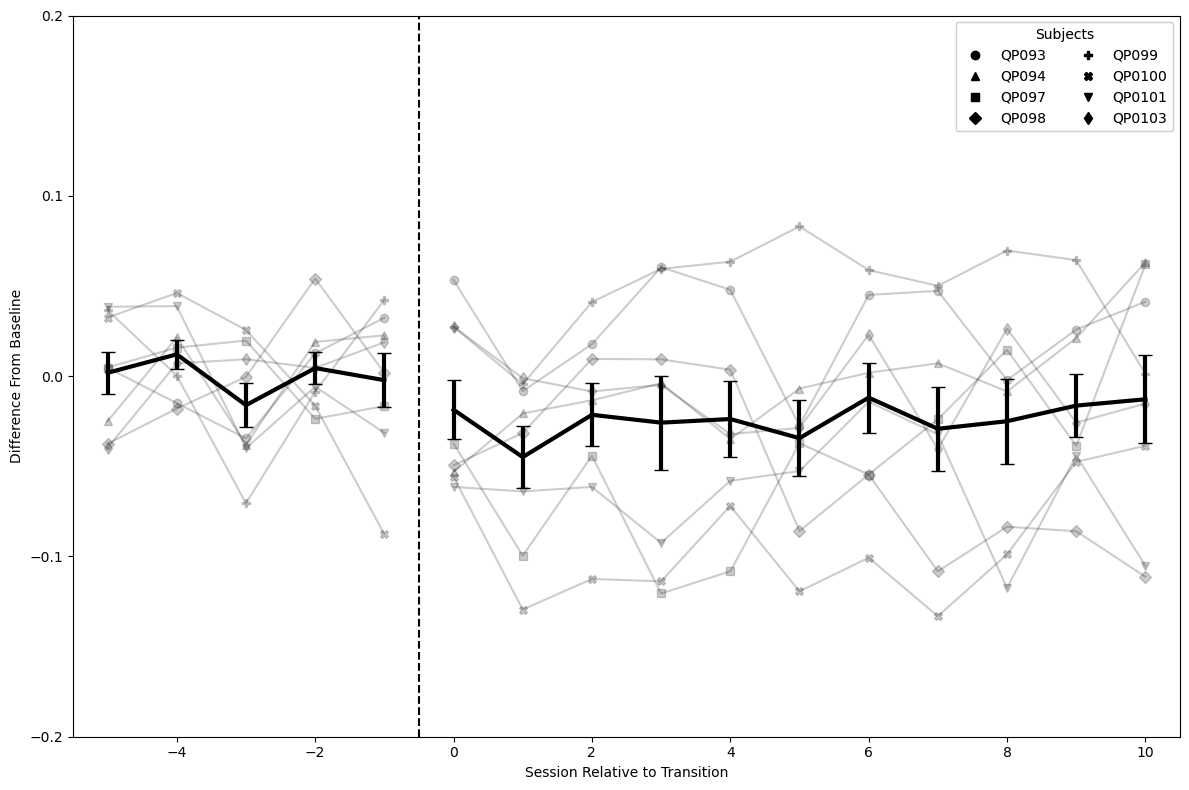

In [127]:
marker_dict = {
                'QP093': 'o',
                'QP094': '^',
                'QP097': 's',
                'QP098': 'D',
                'QP099': 'P',
                'QP0100': 'X',
                'QP0101': 'v',
                'QP0103': 'd'
                }

fig, ax = plt.subplots(figsize=(12, 8))

ax.plot(baseline_diff_means.index, baseline_diff_means, color='k', linestyle='-', label='Baseline')
ax.errorbar(baseline_diff_means.index, baseline_diff_means, yerr=baseline_diff_sems, color='k', fmt='-', 
             capsize=5, linewidth=3)
# plot individual data points
for participant_id in unique_ids:
    participant_df = delta_df[delta_df['Participant_ID'] == participant_id]
    ax.plot(participant_df['Date_Relative_Transition'], participant_df['Baseline_Diff'],
            color='k', marker=marker_dict[participant_id], alpha=0.2)

ax.plot(post_transition_diff_means.index, post_transition_diff_means, color='k', linestyle='-', label='Post-Transition')
ax.errorbar(post_transition_diff_means.index, post_transition_diff_means, yerr=post_transition_diff_sems, color='k', fmt='-',
                capsize=5, linewidth=3)

# plot individual data points
for participant_id in unique_ids:
    participant_df = delta_df[(delta_df['Participant_ID'] == participant_id) & (delta_df['Date_Relative_Transition'] >= 0)]
    ax.plot(participant_df['Date_Relative_Transition'], participant_df['Diff_Post_Transition'],
            color='k', marker=marker_dict[participant_id], alpha=0.2)
    


ax.set_xlim(-5.5, days_after_transition + 0.5)
ax.set_ylim(-0.2, 0.2)
ax.set_yticks(np.arange(-0.2, 0.21, 0.1))
ax.set_xlabel('Session Relative to Transition')
ax.set_ylabel('Difference From Baseline')
ax.axvline(-0.5, color='k', linestyle='--')

marker_lines = [plt.Line2D([0], [0], color='black', marker=marker, linestyle='') for marker in marker_dict.values()]
marker_labels = list(marker_dict.keys())
ax.legend(marker_lines, marker_labels, loc='lower left', title='Markers', ncol=2)
ax.add_artist(ax.legend(marker_lines, marker_labels, loc='upper right', title='Subjects', ncol=2))

plt.tight_layout()
# save in the figures folder
plt.savefig(figs_path + 'Discrete_Discrete_Transition_Diff_Sound_Cat.pdf', bbox_inches = 'tight', dpi = 300)
plt.show()


In [ ]:
# break execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

# Pro Anti

In [139]:
Animal_List = data_path = '/Volumes/akrami/Quentin/Head_Fixed_Behavior/Data/'
protocol = 'PRO_ANTI'
data_type = 'Trial_Summary'

Animal_List = [
              'QP069', 
              'QP070', 'QP077', 'QP083', 'QP084', 'QP085', 'QP090', 'QP091', 'QP092',  'QP0104',  'QP0105', 'QP0106', 'QP0107', 'QP0108', 
              'QP0112'
              ]

# Define the path to the cache file
cache_path = '/Users/quentin/Desktop/HeadFixedBehavior/Data/'
cache_file = os.path.join(cache_path, "all_data_PA.pkl")

# Define the path to the figures
figs_path = '/Users/quentin/Desktop/HeadFixedBehavior/Analysis/Figures/'

# Check if the cache file exists
if os.path.exists(cache_file):
    # If the cache file exists, load the data from the cache
    with open(cache_file, "rb") as f:       
        all_data_PA = pickle.load(f)
else:
    # If the cache file does not exist, load the data from the remote server
    all_data_PA = pd.DataFrame()
    for animal in Animal_List:
        try:
            # Load the data for the current animal and add it to the dictionary
            animal_data = get_animal_data(data_path,
                                             animal, 
                                             protocol,
                                             data_type)
            all_data_PA = pd.concat([all_data_PA, animal_data])
        except:
            # If there is an error loading the data, skip the current animal
            pass

    # Save the data to the cache file
    with open(cache_file, "wb") as f:
        pickle.dump(all_data_PA, f)

In [ ]:
df = all_data_PA

In [140]:
PA_column_info = {
    'Date': {'dtype': str, 
             'rename': None, 
             'value_mapping': None},
    'Participant_ID': {'dtype': str, 
                       'rename': ['Animal_ID'], 
                       'value_mapping': None},
    'Protocol': {'dtype': str,
                 'rename': None,
                 'value_mapping': None},
    'Stage': {'dtype': str,
                'rename': None,
                'value_mapping': {'Habituation': [1, 'Habituation', 'Stage_1'],
                                  'Lick_To_Release': [2, 'Lick_To_Release', 'Stage_2'],
                                  'Three_And_Three': [3, 'Three_And_Three', 'Stage_3'],
                                  'Full_Task_Disc': [4, 'Full_Task_Disc', 'Stage_4'],
                                  'Full_Task_Cont': [5, 'Full_Task_Cont', 'Stage_5']}},
    'Trial': {'dtype': 'Int64',
              'rename': ['TrialNumber', 'Trial_Number'],
              'value_mapping': None},
    'choice': {'dtype': 'Int64', 
               'rename': ['FirstLick', 'First_Lick'], 
               'value_mapping': {0: 'Left', 1: 'Right'}},
    'Stim_Relative': {'dtype': float,
                        'rename': None,
                        'value_mapping': None},
    'correct': {'dtype': 'Int64',
                'rename': ['Correct', 'correct'],
                'value_mapping': {1: [True, '1', 'True'],
                                  0: [False, '0', 'False']}},
    'Trial_Outcome': {'dtype': str, 
                      'rename': ['TrialOutcome'], 
                      'value_mapping': {'Correct': ['Correct', 'correct', 1], 
                                        'Incorrect': ['Incorrect', 'incorrect', 0], 
                                        'No_Response': ['No Response', 'no_response', -1, 'Abort']}},
    'no_response': {'dtype': bool,
                    'rename': ['AbortTrial', 'Abort_Trial'],
                    'value_mapping': None},
    'Response_Latency': {'dtype': float,
                        'rename': None,
                        'value_mapping': None},
    'Nb_Of_Stim': {'dtype': 'Int32',
                    'rename': None,
                    'value_mapping': None},
    'Stim_Type': {'dtype': str,
                  'rename': None,
                  'value_mapping': None},
    'Anti_Bias': {'dtype': bool,
                  'rename': ['AntiBias', 'Anti_Bias'],
                  'value_mapping': None},
    'Sound_Contingency': {'dtype': str,
                          'rename': None,
                          'value_mapping': None},
    'P_Right': {'dtype': float,
                'rename': None,
                'value_mapping': None},
    'Distribution': {'dtype': str,
                     'rename': None,
                     'value_mapping': None},
    'Trial_End_Time': {'dtype': float,
                      'rename': ['Time', 'Trial_End_Time'],
                      'value_mapping': None},
    'File_ID': {'dtype': str,   
                'rename': None,
                'value_mapping': None},
    'Air_Puff_Contingency': {'dtype': str,
                             'rename': ['Trial_State'],
                             'value_mapping': {'Pro': [0],
                                                    'Anti': [1]}},
    'Air_Puff_Side': {'dtype': 'Int64', 
                      'rename': ['AirPuff_Side'],
                      'value_mapping': {1: [1, 1.0, 'Right', '1', '1.0'], 
                                        0: [0, 0.0, 'Left', '0', '0.0']}},
                                            
}

pa_df = standardize_dataframe(all_data_PA, PA_column_info)
# only keep rows where 'Participant_ID' is in Animal_List
pa_df = pa_df[pa_df['Participant_ID'].isin(Animal_List)].reset_index(drop=True)

In [ ]:
# Break execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

In [ ]:
# select data only for QP092
animal = 'QP085'
transiton_type = 'discrete_discrete'
filter_date = True
start_date = transition_dict[animal][transiton_type]['start_date']
end_date = transition_dict[animal][transiton_type]['end_date']

transition_date = transition_dict[animal][transiton_type]['transition_date']
plot_transition = True

sub_df = pa_df[pa_df['Participant_ID'] == animal].reset_index(drop=True)
sub_df = sub_df[sub_df.Stage == 'Full_Task_Disc'].reset_index(drop=True)
sub_df = sub_df[sub_df['correct'].isin([0, 1])].reset_index(drop=True)
sub_df['Nb_Of_Stim'] = sub_df['Nb_Of_Stim'].astype('category')
# remove no_response trials
sub_df = sub_df[sub_df['no_response'] == False].reset_index(drop=True)
#
if filter_date:
    sub_df = sub_df[(sub_df.Date >= start_date) & (sub_df.Date <= end_date)].reset_index(drop=True)

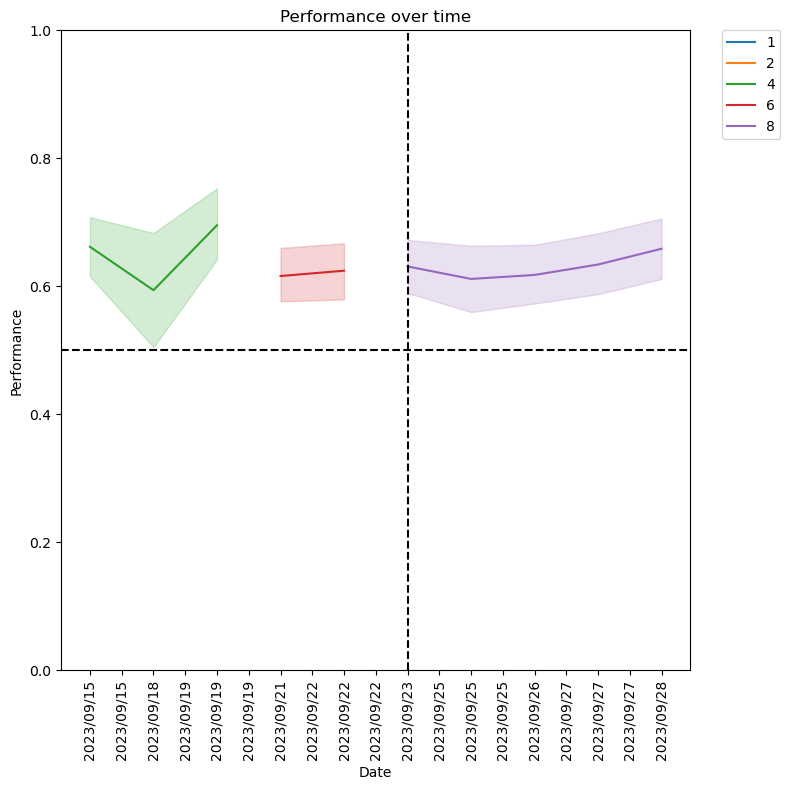

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.lineplot(data=sub_df, x='Date', y='correct', ax=ax,
                hue = 'Nb_Of_Stim',
                # hue = 'Stage',
                ci=95)
ax.axhline(0.5, color='k', linestyle='--')
ax.set_ylim(0, 1)
ax.xaxis.set_major_locator(MaxNLocator(20))
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('Date')
ax.set_ylabel('Performance')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
if plot_transition:
    ax.axvline(transition_date, color='k', linestyle='--')
ax.set_title('Performance over time')
plt.tight_layout()
plt.show()

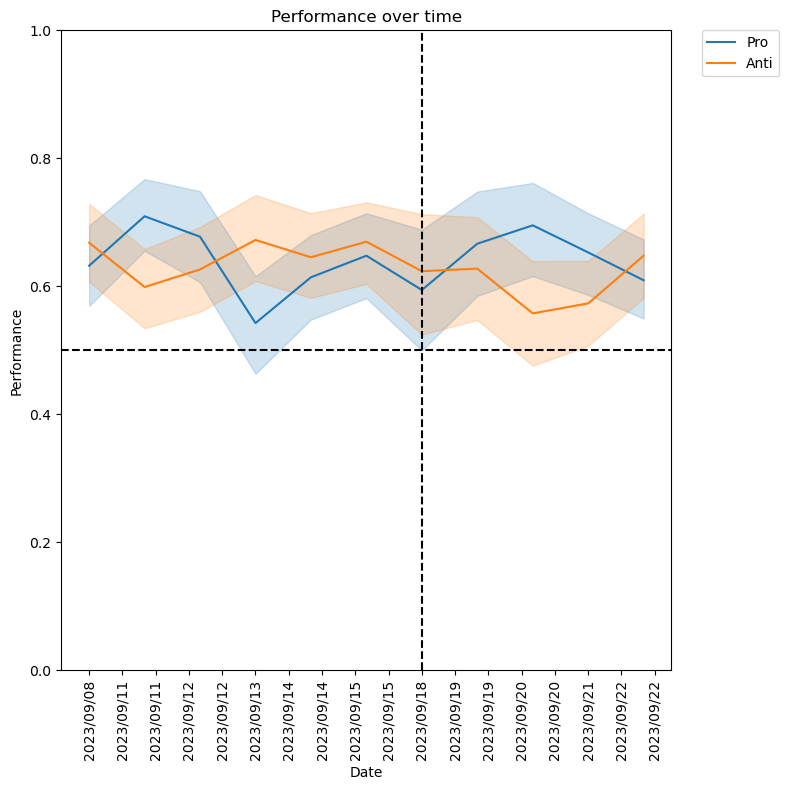

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))

sns.lineplot(data=sub_df, x='Date', y='correct', ax=ax,
                hue = 'Air_Puff_Contingency',
                ci=95)

ax.axhline(0.5, color='k', linestyle='--')
ax.set_ylim(0, 1)
ax.xaxis.set_major_locator(MaxNLocator(20))
ax.tick_params(axis='x', rotation=90)
ax.set_xlabel('Date')
ax.set_ylabel('Performance')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
if plot_transition:
    ax.axvline(transition_date, color='k', linestyle='--')
ax.set_title('Performance over time')
plt.tight_layout()
plt.show()

In [ ]:
# break execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

## Discrete-Discete transition

In [ ]:
# remove Date == 2023/10/23 for QP084 (not enough trials)
pa_df = pa_df[~((pa_df['Participant_ID'] == 'QP084') & (pa_df['Date'] == '2023/10/23'))].reset_index(drop=True)

In [ ]:
def align_dates_to_transition(participant, df, transition_dict, transition_type):
    # Create a copy of the data slice to avoid SettingWithCopyWarning
    participant_data = df[df['Participant_ID'] == participant].copy()

    # Identify the transition date for the participant
    transition_date = pd.to_datetime(transition_dict[participant][transition_type]['transition_date'])
    recovery_date = pd.to_datetime(transition_dict[participant][transition_type]['end_date'])

    # Convert dates in the dataframe to pandas datetime for arithmetic operation
    participant_data['Date'] = pd.to_datetime(participant_data['Date'])

    # Calculate relative days as integers
    participant_data['Date_Relative_Transition'] = (participant_data['Date'] - transition_date).dt.days
    participant_data['Date_Relative_Recovery'] = (participant_data['Date'] - recovery_date).dt.days

    # Convert 'Date' back to string if needed
    participant_data['Date'] = participant_data['Date'].dt.strftime('%Y/%m/%d')

    return participant_data

In [ ]:
# Create an empty dataframe to collect all processed data
processed_data = pd.DataFrame()
p_ids = ['QP069', 'QP077', 'QP083', 'QP084', 'QP085', 'QP092']
# Process data for each participant
for participant in p_ids:
    # Check if transition dates are available for the participant
    if pd.notna(transition_dict[participant]['discrete_discrete']['start_date']):
        participant_data = align_dates_to_transition(participant, pa_df[pa_df['Participant_ID'] == participant], transition_dict, 'discrete_discrete')
        processed_data = pd.concat([processed_data, participant_data])

# Reset index of the new dataframe
pa_df = processed_data.reset_index(drop=True)


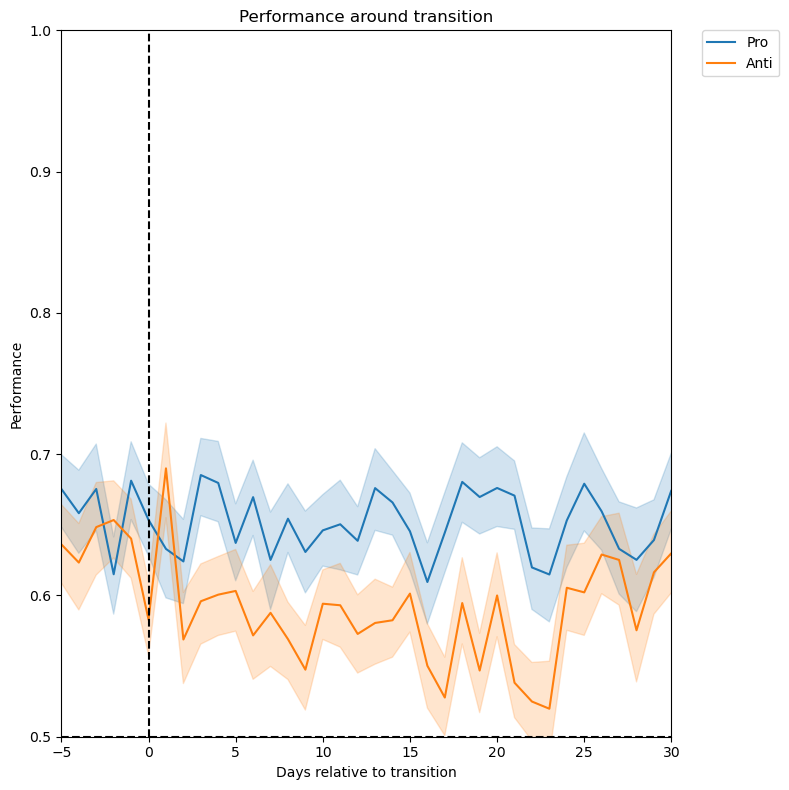

In [ ]:
# only keep rows where 'Air_Puff_Contingency' is in ['Pro', 'Anti']
sub_df = pa_df[pa_df['Air_Puff_Contingency'].isin(['Pro', 'Anti'])].reset_index(drop=True)
# remove no_response trials
sub_df = sub_df[sub_df['no_response'] == False].reset_index(drop=True)
fig, ax = plt.subplots(figsize=(8, 8))

sns.lineplot(data=sub_df, x='Relative_Date', y='correct', ax=ax,
                hue = 'Air_Puff_Contingency',
                ci=95)
ax.axhline(0.5, color='k', linestyle='--')
ax.set_ylim(0.5, 1)
ax.set_xlim(-5, 30)
# ax.xaxis.set_major_locator(MaxNLocator(20))
ax.tick_params(axis='x', rotation=0)
ax.set_xlabel('Days relative to transition')
ax.set_ylabel('Performance')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
# vertical line at relative date 0
ax.axvline(0, color='k', linestyle='--')
ax.set_title('Performance around transition')
plt.tight_layout()
plt.show()


In [ ]:
# break execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

## Prepare data for delta plots

In [128]:
# remove Date == 2023/10/23 for QP084 (not enough trials)
sub_df = pa_df[~((pa_df['Participant_ID'] == 'QP084') & (pa_df['Date'] == '2023/10/23'))].reset_index(drop=True)

# remove the rows where Participant_ID in QP069 and Stage is Full_Task_Cont
sub_df = sub_df[~((sub_df['Participant_ID'] == 'QP069') & (sub_df['Stage'] == 'Full_Task_Cont'))].reset_index(drop=True)

# remmove no_response trials
sub_df = sub_df[sub_df['no_response'] == False].reset_index(drop=True)

# only keep rows where 'Air_Puff_Contingency' is in ['Pro', 'Anti']
sub_df = sub_df[sub_df['Air_Puff_Contingency'].isin(['Pro', 'Anti'])].reset_index(drop=True)

# drops rows where 'correct', 'Air_Puff_Contingency', 'Participant_ID' are nan
# sub_df = sub_df.dropna(subset=['correct', 'Air_Puff_Contingency', 'Participant_ID']).reset_index(drop=True)

In [129]:
# Create an empty dataframe to collect all processed data
processed_data = pd.DataFrame()
p_ids = ['QP069', 'QP077', 'QP083', 'QP084', 'QP085', 'QP092']
# Process data for each participant
for participant in p_ids:
    # Check if transition dates are available for the participant
    # if pd.notna(transition_dict[participant]['discrete_discrete']['start_date']):
    participant_data = align_dates_to_transition(participant, sub_df[sub_df['Participant_ID'] == participant], transition_dict, 'discrete_discrete')
    processed_data = pd.concat([processed_data, participant_data])

# Reset index of the new dataframe
sub_df = processed_data.reset_index(drop=True)

In [130]:
def reindex_relative_dates(group, reference_column):
    # Sort the dates
    sorted_dates = sorted(group[reference_column].unique())
    
    # Find the index of 0, if it exists
    zero_index = sorted_dates.index(0) if 0 in sorted_dates else None

    # Reindex negative dates
    neg_index = -1
    for i in range(zero_index - 1, -1, -1):
        if sorted_dates[i] != neg_index:
            group.loc[group[reference_column] == sorted_dates[i], reference_column] = neg_index
        neg_index -= 1

    # Reindex positive dates
    pos_index = 1
    for i in range(zero_index + 1, len(sorted_dates)):
        if sorted_dates[i] != pos_index:
            group.loc[group[reference_column] == sorted_dates[i], reference_column] = pos_index
        pos_index += 1

    return group

# drop rows where 'Date_Relative_Transition' or 'Date_Relative_Recovery' is NaN
sub_df = sub_df.dropna(subset=['Date_Relative_Transition']).reset_index(drop=True)
sub_df = sub_df.dropna(subset=['Date_Relative_Recovery']).reset_index(drop=True)

# Apply the reindexing function to each participant
sub_df = sub_df.groupby('Participant_ID').apply(lambda x: reindex_relative_dates(x, 'Date_Relative_Transition')).reset_index(drop=True)
sub_df = sub_df.groupby('Participant_ID').apply(lambda x: reindex_relative_dates(x, 'Date_Relative_Recovery')).reset_index(drop=True)


In [131]:
# # Break execution at this cell
# raise KeyboardInterrupt("Stopped execution at this cell.")

In [132]:
# only keep data where the Relative_Date is between -4 and 30 (inclusive)
sub_df = sub_df[(sub_df['Date_Relative_Transition'] >= -5) & (sub_df['Date_Relative_Transition'] <= 40)].reset_index(drop=True)

In [ ]:
# Break execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

## Find recovery date for every participant

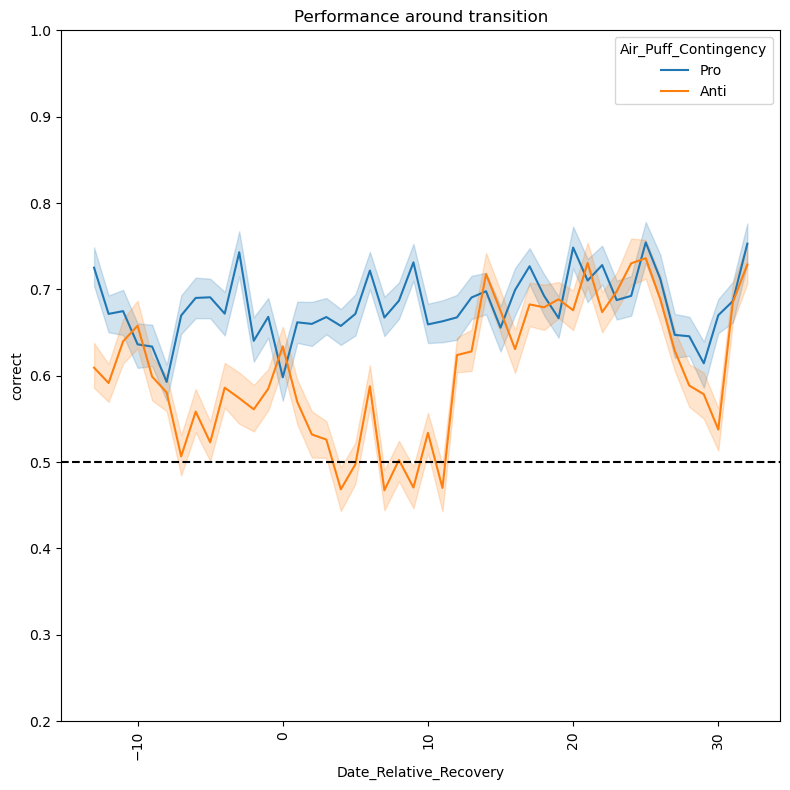

In [ ]:
# only keep rows where 'Air_Puff_Contingency' is in ['Pro', 'Anti']
p_df = sub_df[sub_df.Participant_ID == 'QP092'].reset_index(drop=True)

fig, ax = plt.subplots(figsize=(8, 8))

sns.lineplot(data=p_df,
             x='Date_Relative_Recovery', y='correct', ax=ax,
                hue = 'Air_Puff_Contingency',
                ci=68)
ax.axhline(0.5, color='k', linestyle='--')
ax.set_ylim(0.2, 1)
# ax.axvline(0, color='k', linestyle='--')
# ax.axvline(8, color='k', linestyle='--')
ax.set_title('Performance around transition')
# add rotation to x-axis labels
ax.tick_params(axis='x', rotation=90)
plt.tight_layout()
plt.show()

In [ ]:
# Break execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

## Delta Plots

In [133]:
unique_ids = sub_df['Participant_ID'].unique()
delta_rows = []

for participant_id in unique_ids:
    # Filter for the current participant
    participant_df = sub_df[sub_df['Participant_ID'] == participant_id].reset_index(drop=True)

    # Calculate baseline means
    baseline_means = participant_df[(participant_df['Date_Relative_Transition'] >= -5) 
                                    & (participant_df['Date_Relative_Transition'] < 0)].groupby('Date_Relative_Transition')['correct'].mean()
    baseline_means_pro = participant_df[(participant_df['Date_Relative_Transition'] >= -5)
                                        & (participant_df['Date_Relative_Transition'] < 0)
                                        & (participant_df['Air_Puff_Contingency'] == 'Pro')].groupby('Date_Relative_Transition')['correct'].mean()
    baseline_means_anti = participant_df[(participant_df['Date_Relative_Transition'] >= -5)
                                        & (participant_df['Date_Relative_Transition'] < 0)
                                        & (participant_df['Air_Puff_Contingency'] == 'Anti')].groupby('Date_Relative_Transition')['correct'].mean()

    mean_baseline_performance = baseline_means.mean()

    baseline_diff = baseline_means - mean_baseline_performance
    baseline_diff_pro = baseline_means_pro - mean_baseline_performance
    baseline_diff_anti = baseline_means_anti - mean_baseline_performance


    # Calculate differences
    pro_means_post_transition = participant_df[(participant_df['Date_Relative_Transition'] >= 0) 
                                               & (participant_df['Air_Puff_Contingency'] == 'Pro')].groupby('Date_Relative_Transition')['correct'].mean()
    anti_means_post_transition = participant_df[(participant_df['Date_Relative_Transition'] >= 0) 
                                                & (participant_df['Air_Puff_Contingency'] == 'Anti')].groupby('Date_Relative_Transition')['correct'].mean()
    pro_diff_post_transition = pro_means_post_transition - mean_baseline_performance
    anti_diff_post_transition = anti_means_post_transition - mean_baseline_performance

    # Determine the range of dates to iterate over
    min_date = -5
    max_date = max(pro_diff_post_transition.index.union(anti_diff_post_transition.index).max(), -1)

    # Prepare data for appending
    for date in range(min_date, max_date + 1):
        date_df = participant_df[participant_df['Date_Relative_Transition'] == date]
        date_relative_recovery = date_df['Date_Relative_Recovery'].iloc[0]
        delta_rows.append({
            'Participant_ID': participant_id,
            'Date_Relative_Transition': date,
            'Date_Relative_Recovery': date_relative_recovery,
            'Baseline_Diff': baseline_diff.get(date, np.nan) if date < 0 else np.nan,
            'Baseline_Diff_Pro': baseline_diff_pro.get(date, np.nan) if date < 0 else np.nan,
            'Baseline_Diff_Anti': baseline_diff_anti.get(date, np.nan) if date < 0 else np.nan,
            'Pro_Diff_Post_Transition': pro_diff_post_transition.get(date, np.nan) if date >= 0 else np.nan,
            'Anti_Diff_Post_Transition': anti_diff_post_transition.get(date, np.nan) if date >= 0 else np.nan
        })

# Create DataFrame from list of dictionaries
delta_df = pd.DataFrame(delta_rows)

# Set appropriate data types
delta_df['Date_Relative_Transition'] = delta_df['Date_Relative_Transition'].astype(int)
delta_df['Baseline_Diff'] = delta_df['Baseline_Diff'].astype(float)
delta_df['Baseline_Diff_Pro'] = delta_df['Baseline_Diff_Pro'].astype(float)
delta_df['Baseline_Diff_Anti'] = delta_df['Baseline_Diff_Anti'].astype(float)
delta_df['Pro_Diff_Post_Transition'] = delta_df['Pro_Diff_Post_Transition'].astype(float)
delta_df['Anti_Diff_Post_Transition'] = delta_df['Anti_Diff_Post_Transition'].astype(float)

# Optional: Sort the DataFrame
delta_df.sort_values(by=['Participant_ID', 'Date_Relative_Transition'], inplace=True)


In [134]:
days_after_transition = 5
days_before_recovery = 5

baseline_diff_means = delta_df[delta_df['Date_Relative_Transition'] < 0].groupby('Date_Relative_Transition')['Baseline_Diff'].mean()
baseline_diff_sems = delta_df[delta_df['Date_Relative_Transition'] < 0].groupby('Date_Relative_Transition')['Baseline_Diff'].sem()
baseline_diff_pro_means = delta_df[delta_df['Date_Relative_Transition'] < 0].groupby('Date_Relative_Transition')['Baseline_Diff_Pro'].mean()
baseline_means_pro_sems = delta_df[delta_df['Date_Relative_Transition'] < 0].groupby('Date_Relative_Transition')['Baseline_Diff_Pro'].sem()
baseline_diff_anti_means = delta_df[delta_df['Date_Relative_Transition'] < 0].groupby('Date_Relative_Transition')['Baseline_Diff_Anti'].mean()
baseline_diff_anti_sems = delta_df[delta_df['Date_Relative_Transition'] < 0].groupby('Date_Relative_Transition')['Baseline_Diff_Anti'].sem()

pro_diff_early_means = delta_df[(delta_df['Date_Relative_Transition'] >= 0) 
                                & (delta_df['Date_Relative_Transition'] <= days_after_transition)].groupby('Date_Relative_Transition')['Pro_Diff_Post_Transition'].mean()
pro_diff_early_sems = delta_df[(delta_df['Date_Relative_Transition'] >= 0)
                                & (delta_df['Date_Relative_Transition'] <= days_after_transition)].groupby('Date_Relative_Transition')['Pro_Diff_Post_Transition'].sem()

anti_diff_early_means = delta_df[(delta_df['Date_Relative_Transition'] >= 0)
                                & (delta_df['Date_Relative_Transition'] <= days_after_transition)].groupby('Date_Relative_Transition')['Anti_Diff_Post_Transition'].mean()
anti_diff_early_sems = delta_df[(delta_df['Date_Relative_Transition'] >= 0)
                                & (delta_df['Date_Relative_Transition'] <= days_after_transition)].groupby('Date_Relative_Transition')['Anti_Diff_Post_Transition'].sem()

pro_diff_late_means = delta_df[(delta_df['Date_Relative_Recovery'] >= -days_before_recovery)
                                & (delta_df['Date_Relative_Recovery'] <= 0)].groupby('Date_Relative_Recovery')['Pro_Diff_Post_Transition'].mean()

pro_diff_late_sems = delta_df[(delta_df['Date_Relative_Recovery'] >= -days_before_recovery)
                                & (delta_df['Date_Relative_Recovery'] <= 0)].groupby('Date_Relative_Recovery')['Pro_Diff_Post_Transition'].sem()

anti_diff_late_means = delta_df[(delta_df['Date_Relative_Recovery'] >= -days_before_recovery)
                                & (delta_df['Date_Relative_Recovery'] <= 0)].groupby('Date_Relative_Recovery')['Anti_Diff_Post_Transition'].mean()

anti_diff_late_sems = delta_df[(delta_df['Date_Relative_Recovery'] >= -days_before_recovery)
                                & (delta_df['Date_Relative_Recovery'] <= 0)].groupby('Date_Relative_Recovery')['Anti_Diff_Post_Transition'].sem()

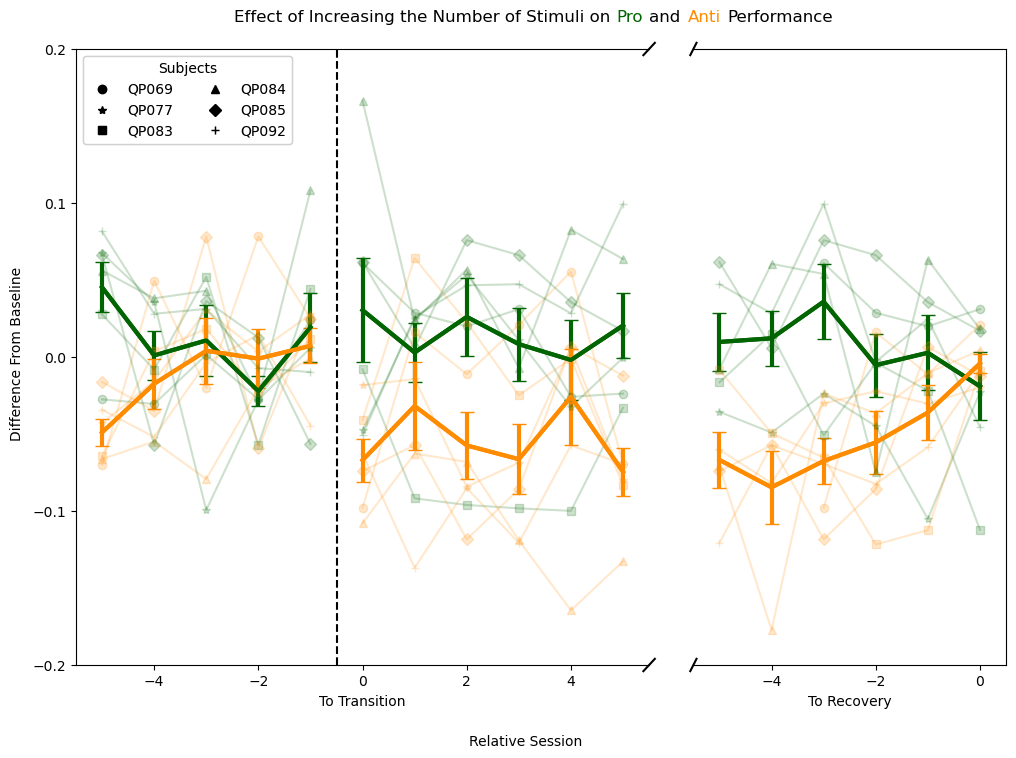

In [135]:
color_dict = {
              'Pro': 'darkgreen', 
              'Anti': 'darkorange'}

# use markers to indicate participants
marker_dict = {'QP069': 'o',
                'QP077': '*',
                'QP083': 's',
                'QP084': '^',
                'QP085': 'D',
                'QP092': '+'}

scaling_factor = (len(baseline_diff_means) + len(pro_diff_early_means)) / len(pro_diff_late_means)
width_ratios = [scaling_factor, 1]  # Adjust these values as needed for your desired widths

fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, facecolor='w', figsize=(12, 8),
                                 gridspec_kw={'width_ratios': width_ratios})

# ax1.plot(baseline_diff_means.index, baseline_diff_means, color='black', label='Combined')
# ax1.errorbar(baseline_diff_means.index, baseline_diff_means, yerr=baseline_diff_sems, color='black', fmt='-', capsize=5)
# plot baseline diff for pro and anti
ax1.plot(baseline_diff_pro_means.index, baseline_diff_pro_means, color= color_dict['Pro'], label='Pro', linewidth=3)
ax1.errorbar(baseline_diff_pro_means.index, baseline_diff_pro_means, yerr=baseline_means_pro_sems, color='darkgreen', fmt='-', 
             capsize=5, linewidth=3)
ax1.plot(baseline_diff_anti_means.index, baseline_diff_anti_means, color= color_dict['Anti'], label='Anti', linewidth=3)
ax1.errorbar(baseline_diff_anti_means.index, baseline_diff_anti_means, yerr=baseline_diff_anti_sems, color='darkorange', fmt='-', 
             capsize=5, linewidth=3)



# plot individual data
for participant in delta_df['Participant_ID'].unique():
    participant_data = delta_df[delta_df['Participant_ID'] == participant]
    # ax1.plot(participant_data['Date_Relative_Transition'], 
    #          participant_data['Baseline_Diff'], color= color_dict['Combined'], alpha=0.2, marker=marker_dict[participant])
    participant_data = delta_df[(delta_df['Participant_ID'] == participant) & (delta_df['Baseline_Diff_Pro'].notna())]
    ax1.plot(participant_data['Date_Relative_Transition'],
                participant_data['Baseline_Diff_Pro'], color= color_dict['Pro'],
                alpha=0.2, marker=marker_dict[participant])
    participant_data = delta_df[(delta_df['Participant_ID'] == participant) & (delta_df['Baseline_Diff_Anti'].notna())]
    ax1.plot(participant_data['Date_Relative_Transition'],
                participant_data['Baseline_Diff_Anti'], color= color_dict['Anti'],
                alpha=0.2, marker=marker_dict[participant])

ax1.plot(pro_diff_early_means.index, pro_diff_early_means, color= color_dict['Pro'], label='Pro', linewidth=3)
ax1.plot(anti_diff_early_means.index, anti_diff_early_means, color= color_dict['Anti'],label='Anti', linewidth=3)
ax1.errorbar(pro_diff_early_means.index, pro_diff_early_means, yerr=pro_diff_early_sems, color='darkgreen', fmt='-', capsize=5, linewidth=3)
ax1.errorbar(anti_diff_early_means.index, anti_diff_early_means, yerr=anti_diff_early_sems, color='darkorange', fmt='-', capsize=5, linewidth=3)
# plot individual data for pro and anti early
for participant in delta_df['Participant_ID'].unique():
    participant_data_early = delta_df[(delta_df['Participant_ID'] == participant) & (delta_df['Pro_Diff_Post_Transition'].notna())
                                      & (delta_df['Date_Relative_Transition'] <= days_after_transition)]
    ax1.plot(participant_data_early['Date_Relative_Transition'],
             participant_data_early['Pro_Diff_Post_Transition'], color= color_dict['Pro'],
                alpha=0.2, marker=marker_dict[participant])
    participant_data_early = delta_df[(delta_df['Participant_ID'] == participant) & (delta_df['Anti_Diff_Post_Transition'].notna())
                                        & (delta_df['Date_Relative_Transition'] <= days_after_transition)]
    ax1.plot(participant_data_early['Date_Relative_Transition'],
             participant_data_early['Anti_Diff_Post_Transition'], color= color_dict['Anti'],
                alpha=0.2, marker=marker_dict[participant])

ax2.plot(pro_diff_late_means.index, pro_diff_late_means, color='darkgreen', label='Pro Diff Post Transition', linewidth=3)
ax2.plot(anti_diff_late_means.index, anti_diff_late_means, color='darkorange', label='Anti Diff Post Transition', linewidth=3)
ax2.errorbar(pro_diff_late_means.index, pro_diff_late_means, yerr=pro_diff_late_sems, color='darkgreen', fmt='-', capsize=5, linewidth=3)
ax2.errorbar(anti_diff_late_means.index, anti_diff_late_means, yerr=anti_diff_late_sems, color='darkorange', fmt='-', capsize=5, linewidth=3)
# plot individual data for pro and anti late
for participant in delta_df['Participant_ID'].unique():
    participant_data_late = delta_df[(delta_df['Participant_ID'] == participant) & (delta_df['Pro_Diff_Post_Transition'].notna())
                                        & (delta_df['Date_Relative_Recovery'] >= -days_before_recovery) & (delta_df['Date_Relative_Recovery'] <= 0)]
    ax2.plot(participant_data_late['Date_Relative_Recovery'],
                participant_data_late['Pro_Diff_Post_Transition'], color= color_dict['Pro'],
                alpha=0.2, marker=marker_dict[participant])
    participant_data_late = delta_df[(delta_df['Participant_ID'] == participant) & (delta_df['Anti_Diff_Post_Transition'].notna())
                                        & (delta_df['Date_Relative_Recovery'] >= -days_before_recovery) & (delta_df['Date_Relative_Recovery'] <= 0)]
    ax2.plot(participant_data_late['Date_Relative_Recovery'],
             participant_data_late['Anti_Diff_Post_Transition'], color= color_dict['Anti'],
                alpha=0.2, marker=marker_dict[participant])

# Setting the x-axis limits
ax1.set_xlim(-5.5, days_after_transition + 0.5)
ax2.set_xlim(-days_before_recovery - 0.5, 0.5)

# Setting the y-axis limits
ax1.set_ylim(-0.2, 0.2)

# vertical line at 0
ax1.axvline(x=-0.5, color='black', linestyle='--')

# Setting the x labels
ax1.set_xlabel('To Transition')
ax2.set_xlabel('To Recovery')

# Hide the spines between ax and ax2
ax1.spines['right'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax1.yaxis.tick_left()
# ax2.set_yticks([])

# Explicitly set y-ticks and y-tick labels for ax1
y_ticks = np.arange(-0.2, 0.21, 0.1)
ax1.set_yticks(y_ticks)
# ax1.set_yticklabels(["{:.2f}".format(tick) for tick in y_ticks])

# Hide y-axis tick labels on ax2
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)

# set x ticks for ax2
ax2.set_xticks(np.arange(-4, 1, 2))

# remove y ticks from ax2
ax1.tick_params(labeltop=False)
ax2.tick_params(labeltop=False)

# Adding diagonal lines to indicate the break
d = .01
kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
ax1.plot((1 - d, 1 + d), (-d, +d), **kwargs)
ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)
kwargs.update(transform=ax2.transAxes)
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)
ax2.plot((-d, +d), (-d, +d), **kwargs)

start_point = (4, 0.1)  # Specify the start coordinates
end_point = (4.1, 0.11)       # Specify the end coordinates


# Legend for colors
color_lines = [plt.Line2D([0], [0], color=color, lw=2) for color in color_dict.values()]
color_labels = list(color_dict.keys())
ax1.legend(color_lines, color_labels, loc='upper left', title='Colors')

# Legend for markers
marker_lines = [plt.Line2D([0], [0], color='black', marker=marker, linestyle='') for marker in marker_dict.values()]
marker_labels = list(marker_dict.keys())
ax1.legend(marker_lines, marker_labels, loc='lower left', title='Markers', ncol=2)

# Ensure the color legend stays visible
ax1.add_artist(ax1.legend(color_lines, color_labels, loc='upper left', title='Contingency')).remove()
ax1.add_artist(ax1.legend(marker_lines, marker_labels, loc='upper left', title='Subjects', ncol=2))

# Adding labels, title, and legend
ax2.legend(loc='upper right').remove()

fig.text(0.5, 0.01, 'Relative Session', ha='center')
fig.text(0.07, 0.5, 'Difference From Baseline', va='center', rotation='vertical')
# plt.suptitle('Effect of Increasing the Number of Stimuli on Pro and Anti Performance', y=0.95)

# Initial position for the first part of the title
title_height = 0.92
title_size = 12
x_pos = 0.57
# Add the first part of the title
fig.text(x_pos, title_height, "Effect of Increasing the Number of Stimuli on", ha='right', va='center', transform=fig.transFigure, fontsize=title_size)
# Adjust x_pos for the next part
x_pos += 0.005  # This value is an estimate and may need adjustment
# Add the colored parts of the title
fig.text(x_pos, title_height, "Pro", color='darkgreen', ha='left', va='center', transform=fig.transFigure, fontsize=title_size)
x_pos += 0.0275
fig.text(x_pos, title_height, "and", ha='left', va='center', transform=fig.transFigure, fontsize=title_size)
x_pos += 0.0325
fig.text(x_pos, title_height, "Anti", color='darkorange', ha='left', va='center', transform=fig.transFigure, fontsize=title_size)
x_pos += 0.0325
# Add the last part of the title
fig.text(x_pos, title_height, "Performance", ha='left', va='center', transform=fig.transFigure, fontsize=title_size)

fig.subplots_adjust(wspace=0.1)  # Adjust this value as needed
# save figure
plt.savefig(figs_path + 'Discrete_Discrete_Transition_Diff_Pro_Anti.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
delta_df

,Participant_ID,Date_Relative_Transition,Date_Relative_Recovery,Baseline_Diff,Baseline_Diff_Pro,Baseline_Diff_Anti,Pro_Diff_Post_Transition,Anti_Diff_Post_Transition
0,QP069,-5,-8,-0.047433,-0.027519,-0.069916,NaN,NaN
1,QP069,-4,-7,0.007104,-0.030470,0.049518,NaN,NaN
2,QP069,-3,-6,-0.008948,0.001441,-0.019936,NaN,NaN
3,QP069,-2,-5,0.024768,-0.027450,0.078280,NaN,NaN
4,QP069,-1,-4,0.024509,0.023824,0.025190,NaN,NaN
...,...,...,...,...,...,...,...,...
255,QP092,37,29,NaN,NaN,NaN,-0.029168,-0.064972
256,QP092,38,30,NaN,NaN,NaN,0.026536,-0.105811
257,QP092,39,31,NaN,NaN,NaN,0.042831,0.041636
258,QP092,40,32,NaN,NaN,NaN,0.109353,0.085179


In [ ]:
# break execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

## Different training stages for best Pro Anti mice

In [292]:
# remove Date == 2023/10/23 for QP084 (not enough trials)
sub_df = pa_df.reset_index(drop=True)

# remmove no_response trials
sub_df = sub_df[sub_df['no_response'] == False].reset_index(drop=True)

# only keep rows where 'Air_Puff_Contingency' is in ['Pro', 'Anti']
sub_df = sub_df[sub_df['Air_Puff_Contingency'].isin(['Pro', 'Anti'])].reset_index(drop=True)

In [293]:
participant = 'QP091'
start_date, end_date = '2023/07/20', '2023/09/29'
# start_date, end_date = '2023/02/20', '2023/12/25'

participant_df = sub_df[(sub_df['Participant_ID'] == participant) & (sub_df['Date'] >= start_date) 
                        & (sub_df['Date'] <= end_date)].reset_index(drop=True)

In [294]:
def calculate_sem_binomial(p, n):
    return np.sqrt(p * (1 - p) / n)

In [295]:
grouped_df_mean = participant_df.groupby(['Date', 'Air_Puff_Contingency'])['correct'].mean().reset_index()
grouped_df_mean.sort_values(by='Date', inplace=True)
grouped_df_len = participant_df.groupby(['Date', 'Air_Puff_Contingency'])['correct'].size().reset_index(name='trials')
grouped_df_len.sort_values(by='Date', inplace=True)
merged_df = pd.merge(grouped_df_mean, grouped_df_len, on=['Date', 'Air_Puff_Contingency']).drop_duplicates().reset_index(drop=True)

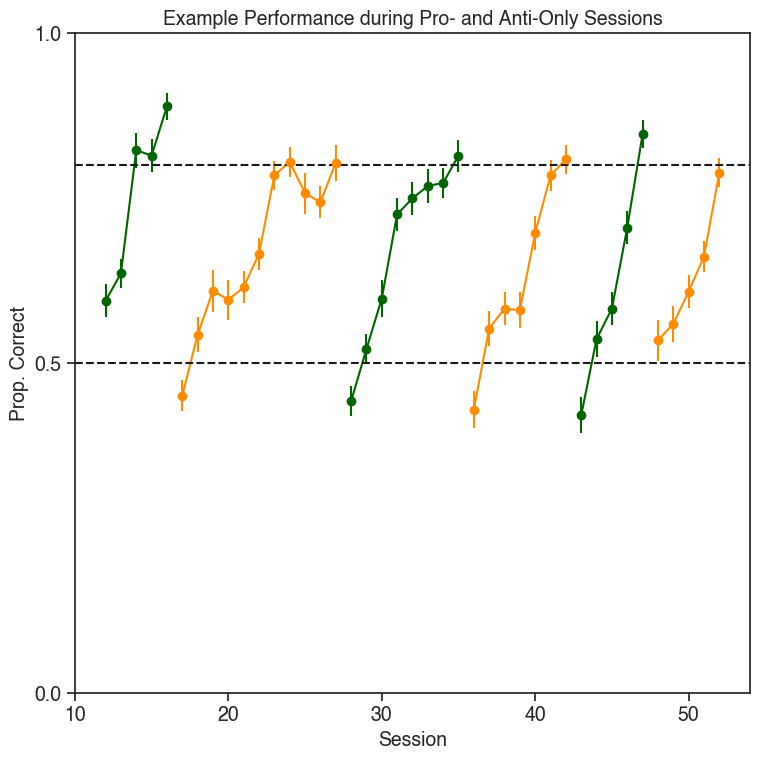

In [296]:
unique_condition_dates = merged_df.groupby('Date').filter(lambda x: len(x) == 1)

# Plotting with error bars using actual trial numbers
plt.figure(figsize=(8, 8))

for contingency, color in zip(['Pro', 'Anti'], ['darkgreen', 'darkorange']):
    df_subset = unique_condition_dates[unique_condition_dates['Air_Puff_Contingency'] == contingency]
    indices = df_subset.index
    correct_values = df_subset['correct']
    trials = df_subset['trials']

    # Calculating SEM for each point
    sem_values = calculate_sem_binomial(correct_values, trials)

    # Plotting points with error bars
    plt.errorbar(indices, correct_values, yerr=sem_values, fmt='o', color=color, label=contingency)

    # Connect points with lines only if they are consecutive
    for i in range(len(indices) - 1):
        if indices[i + 1] - indices[i] == 1:
            plt.plot(indices[i:i + 2], correct_values[i:i + 2], color=color)

# Adding the dashed lines and other plot configurations
plt.axhline(0.5, color='k', linestyle='--')
plt.axhline(0.8, color='k', linestyle='--')
plt.ylim(0, 1)
plt.xticks(np.arange(10, 60, 10))
plt.yticks(np.arange(0, 1.1, 0.5))
plt.title("Example Performance during Pro- and Anti-Only Sessions")
plt.xlabel("Session")
plt.ylabel("Prop. Correct")
plt.legend().remove()
plt.tight_layout()
# save in figures folder
plt.savefig(figs_path + 'QP091_Pro_Only_Anti_Only_Performance.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [245]:
# break execution at this cell
raise KeyboardInterrupt("Stopped execution at this cell.")

KeyboardInterrupt: Stopped execution at this cell.

In [297]:
pa_df

,Date,Participant_ID,Trial,choice,correct,Trial_Outcome,no_response,Response_Latency,Air_Puff_Contingency,Air_Puff_Side,Anti_Bias,Stage,Trial_End_Time,File_ID,Nb_Of_Stim,Stim_Relative,P_Right,Protocol,Sound_Contingency,Stim_Type,Distribution
0,2023/01/31,QP069,1,-2147483648,0,-2147483648.0,False,-2.147484e+09,-2147483648.0,1,False,Habituation,53341.726810,/Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
1,2023/01/31,QP069,2,-2147483648,0,-2147483648.0,False,-2.147484e+09,-2147483648.0,1,False,Habituation,53357.542221,/Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
2,2023/01/31,QP069,3,-2147483648,0,-2147483648.0,False,-2.147484e+09,-2147483648.0,1,False,Habituation,53373.351232,/Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
3,2023/01/31,QP069,4,-2147483648,0,-2147483648.0,False,-2.147484e+09,-2147483648.0,0,False,Habituation,53389.169933,/Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
4,2023/01/31,QP069,5,-2147483648,0,-2147483648.0,False,-2.147484e+09,-2147483648.0,1,False,Habituation,53404.982118,/Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...,<NA>,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
941794,2023/11/16,QP0112,517,1,0,No_Response,True,9.999000e+03,Pro,0,True,Full_Task_Disc,49497.362662,/Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...,2,-1.0,0.470412,PRO_ANTI,Low_Left_High_Right,WN,NaN
941795,2023/11/16,QP0112,518,1,0,No_Response,True,9.983000e+03,Pro,1,True,Full_Task_Disc,49511.038758,/Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...,2,-1.0,0.470412,PRO_ANTI,Low_Left_High_Right,WN,NaN
941796,2023/11/16,QP0112,519,1,0,No_Response,True,9.999000e+03,Pro,0,True,Full_Task_Disc,49524.704474,/Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...,2,-1.0,0.470412,PRO_ANTI,Low_Left_High_Right,WN,NaN
941797,2023/11/16,QP0112,520,1,0,No_Response,True,9.999000e+03,Pro,1,True,Full_Task_Disc,49538.370061,/Volumes/akrami/Quentin/Head_Fixed_Behavior/Da...,2,-1.0,0.470412,PRO_ANTI,Low_Left_High_Right,WN,NaN
